# Trabalho Prático - Computação Quântica

Trabalho realizado por:
> Gonçalo Silva (A95696) 
<br>
> Bárbara Brito (A95973)

Desenho da fórmula booleana 3-SAT
$$ f(v1, v2, v3) = (\neg v1 \lor \neg v2 \lor \neg v3) \land 
(v1 \lor \neg v2 \lor \neg v3) \land
(\neg v1 \lor v2 \lor v3) \land
(v1 \lor \neg v2 \lor v3) \land
(v1 \lor v2 \lor \neg v3)$$

| v1 | v2 | v3 | f | Resultado 
| :-: | :-: | :-: | :-: | :-:
| 0 | 0 | 0 | 1 | É solução | 
| 0 | 0 | 1 | 0 | Não é solução porque $f$ é falso |
| 0 | 1 | 0 | 0 | Não é solução porque $f$ é falso |
| 0 | 1 | 1 | 0 | Não é solução porque $f$ é falso |
| 1 | 0 | 0 | 0 | Não é solução porque $f$ é falso |
| 1 | 0 | 1 | 1 | É solução |
| 1 | 1 | 0 | 1 | É solução |
| 1 | 1 | 1 | 0 | Não é solução porque $f$ é falso |

### Implementação do algoritmo de Grover
Comecemos por importar as bibliotecas necessárias para a realização do projeto.

In [1]:
import math
from qiskit import Aer, QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.visualization import plot_histogram
from qiskit.utils import QuantumInstance
from qiskit.algorithms import Grover, AmplificationProblem
from qiskit.circuit.library import PhaseOracle, ZGate, MCXGate
import numpy as np

A função `execute_circuit` executa um determinado circuito quântico.

In [2]:
def execute_circuit(qc, shots=1024, decimal=False, reversed=True):
    
    #define backend
    device = Aer.get_backend('qasm_simulator')
    #get counts
    counts = execute(qc, device, shots=shots).result().get_counts()
    
    if decimal:
        if reversed:
            counts = dict((int(a[::-1],2),b) for (a,b) in counts.items())
        else:
            counts = dict((int(a,2),b) for (a,b) in counts.items())
    else:
        if reversed:
            counts = dict((a[::-1],b) for (a,b) in counts.items())
        else:
            counts = dict((a,b) for (a,b) in counts.items())

    return counts

#### Inicialização
Para a construção do circuito quântico, é necessário saber quantos qubits serão utilizados. Neste caso, utilizamos um total de 9 qubits. 3 qubits para representar as variáveis ($v1, v2, v3$), 5 qubits para as claúsula (1 por cada claúsula) e 1 qubit para o resultado final. Os estados são inicializados todos com a mesma amplitude. Para tal, é lhes aplicada a gate de $\textit{Hadamar}$.

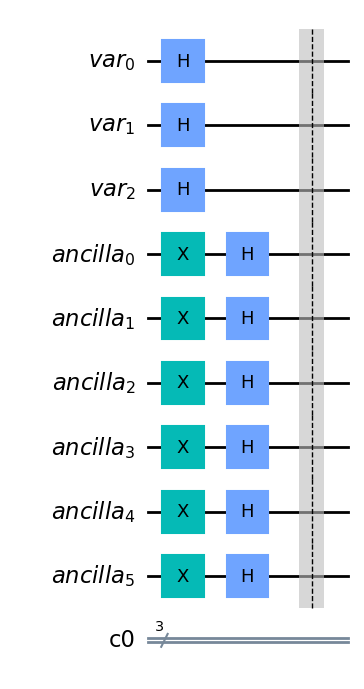

In [3]:
qubits = 9

#qubits das variáveis
qr = QuantumRegister(3, name="var")
#qubits das cláusulas
ancilla = QuantumRegister(6, name="ancilla")
cr = ClassicalRegister(3)
qc = QuantumCircuit(qr, cr, ancilla)

#sobreposição uniforme
qc.h(qr)

#inicialização
qc.x(ancilla)
qc.h(ancilla)

qc.barrier()
qc.draw(output="mpl")

#### Oráculo
O oráculo é responsável pelo cálculo dos valores das clásulas.
<br>
Para que não existam disjunções na fórmula, aplicou-se dupla negação, resultando na seguinte fórmula 3-SAT:
$$ f(v1, v2, v3) = 
\neg (v1 \land v2 \land v3) \land
\neg (\neg v1 \land v2 \land v3) \land
\neg (v1 \land \neg v2 \land \neg v3) \land
\neg (\neg v1 \land v2 \land \neg v3) \land
\neg (\neg v1 \land \neg v2 \land v3)$$
<br><br>
A estratégia utilizada baseia-se em negar todas as variáveis da clásula aplicando a gate $X$, desde que as mesmas não estejam já negadas. De seguida, aplica-se a gate $MCX$, onde os qubits de controlo são os correspondentes às 3 variáveis e o alvo é o qubit da ancilla correspondente à clásula em questão. Por fim, nega-se o qubit da ancilla aplicando a gate $X$, assim como os qubits de controlo anteriormente negados, com o objetivo de anular a negação inicial.
<br>
Quanto ao resultado final, através da gate $MCX$, utiliza-se os qubits da ancilla como qubits de controlo exceto o último, o qual corresponde ao qubit que representa o resultado final, sendo este o alvo.

In [4]:
def oracle(qr, ancilla):
    qc = QuantumCircuit(qr, ancilla)
    for i in range(5):
        if i == 0:
            qc.mcx(qr, ancilla[i])
            qc.x(ancilla[i])
        elif i == 1:
            qc.x(qr[0])
            qc.mcx(qr, ancilla[i])
            qc.x(ancilla[i])
            qc.x(qr[0])
        elif i == 2:
            qc.x(qr[1])
            qc.x(qr[2])
            qc.mcx(qr, ancilla[i])
            qc.x(ancilla[i])
            qc.x(qr[1])
            qc.x(qr[2])
        elif i == 3:
            qc.x(qr[0])
            qc.x(qr[2])
            qc.mcx(qr, ancilla[i])
            qc.x(ancilla[i])
            qc.x(qr[0])
            qc.x(qr[2])
        elif i == 4:
            qc.x(qr[0])
            qc.x(qr[1])
            qc.mcx(qr, ancilla[i])
            qc.x(ancilla[i])
            qc.x(qr[0])
            qc.x(qr[1])
    
    qc.mcx(ancilla[:-1], ancilla[-1])
    
    qc.barrier()
    
    return qc
    

#### Difusor
O difusor amplifica a probabilidade de se obter o resultado pretendido.

In [5]:
def diffuser(qr, ancilla):
    qc = QuantumCircuit(qr, ancilla)
    
    qc.h(qr)
    qc.x(qr)
    qc.h(qr[-1])
    
    qc.mcx(qr[:-1], qr[-1])
    
    qc.h(qr[-1])
    qc.x(qr)
    qc.h(qr)

    qc.barrier()
    return qc

### Solução para 1 iteração

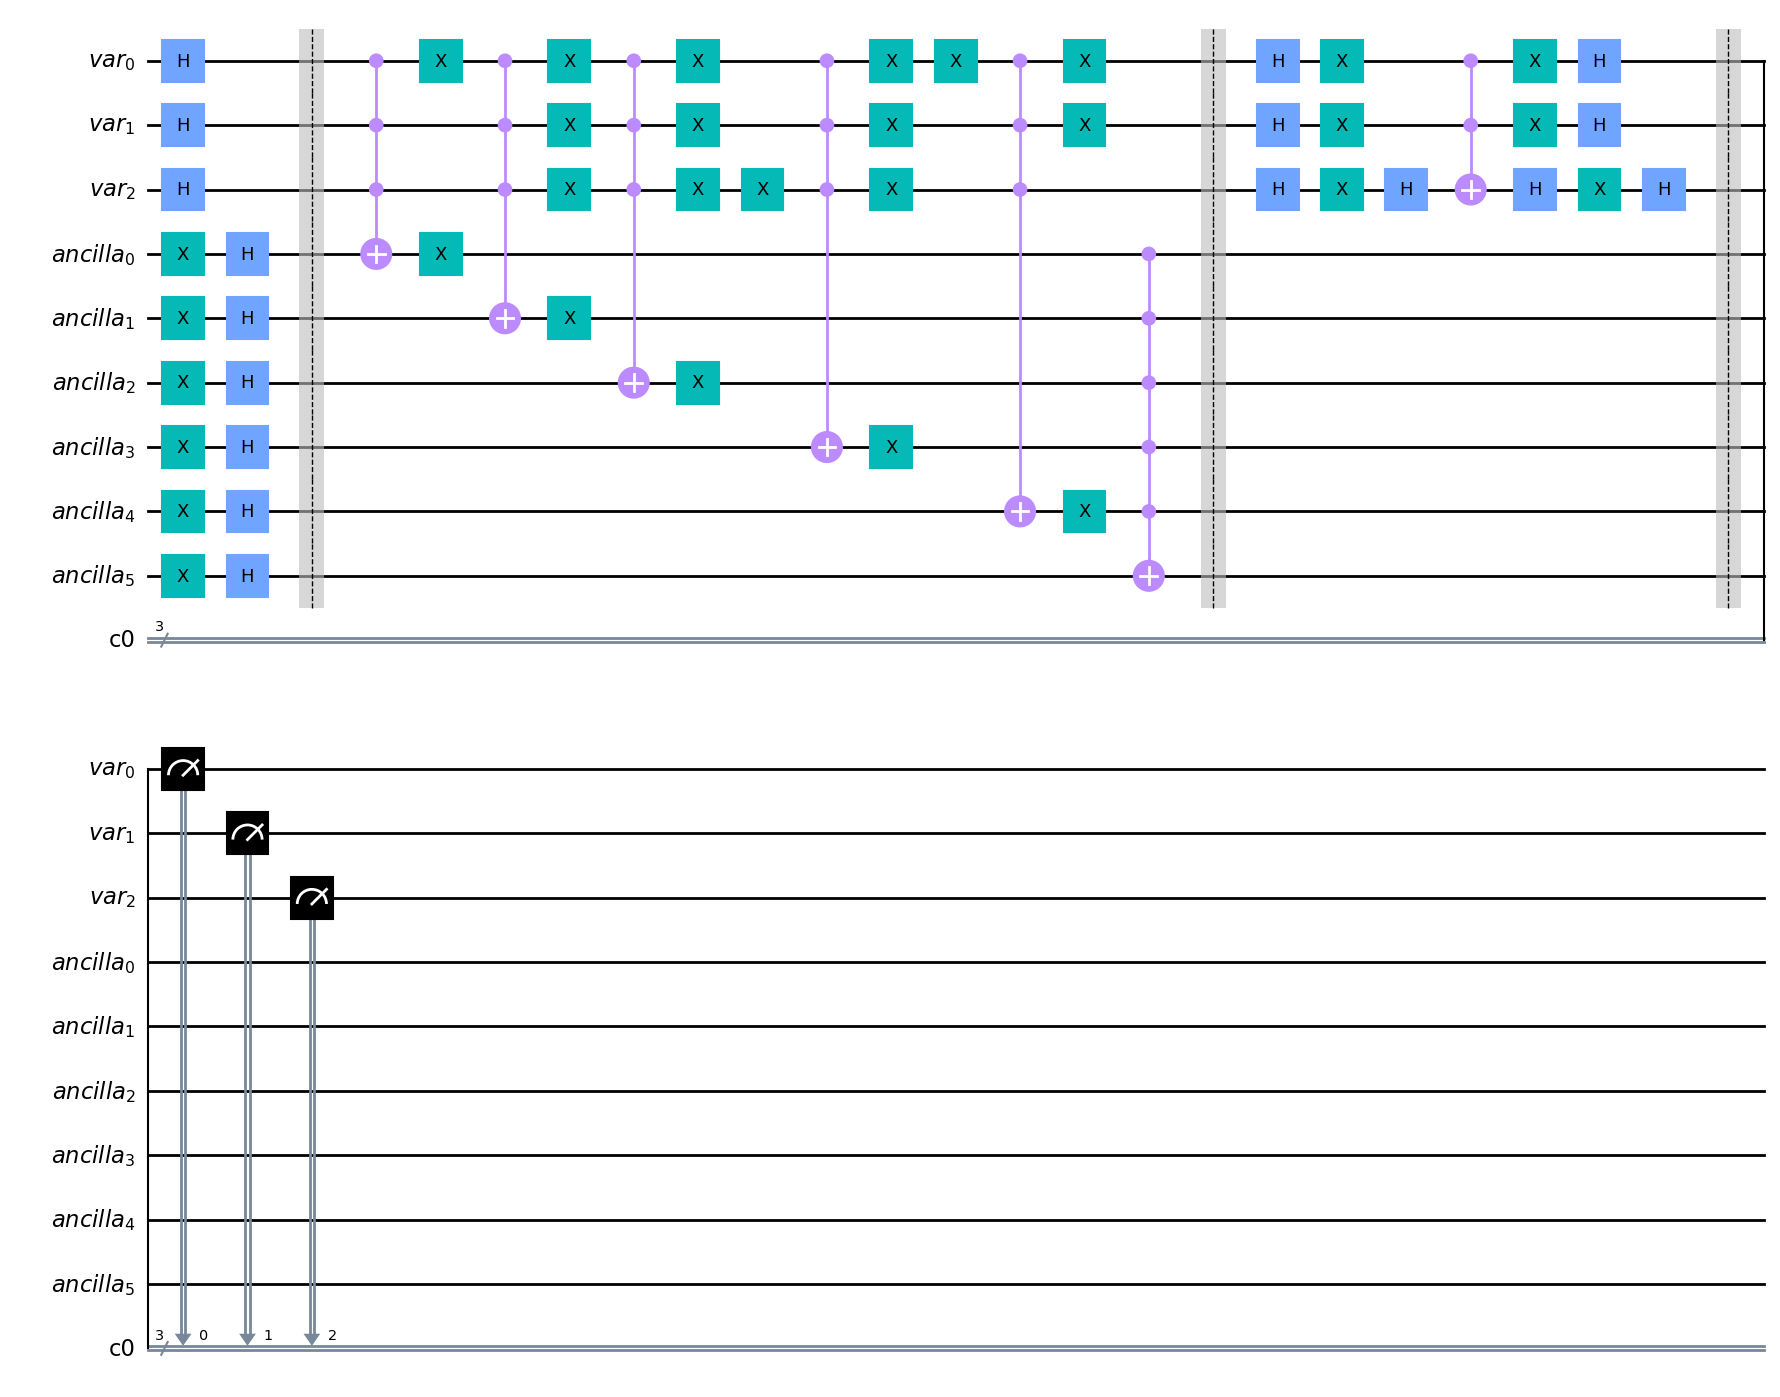

In [6]:
qc = qc.compose(oracle(qr, ancilla))
qc = qc.compose(diffuser(qr, ancilla))

qc.measure(qr, cr)
qc.draw(output="mpl")

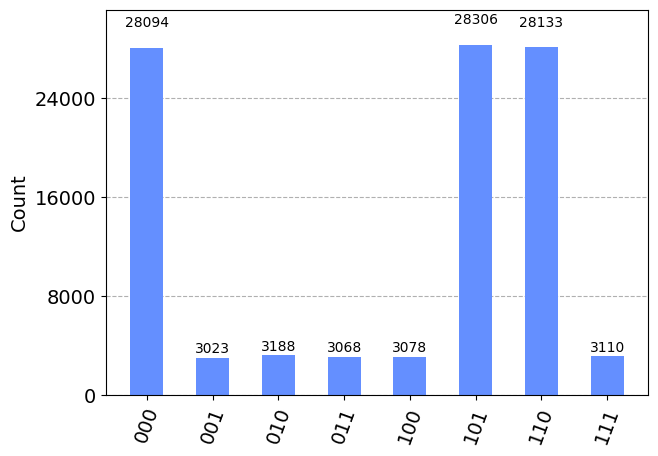

In [7]:
counts = execute_circuit(qc,shots=100000, reversed=True)
plot_histogram(counts)

### Solução para o número de iterações genérico

1


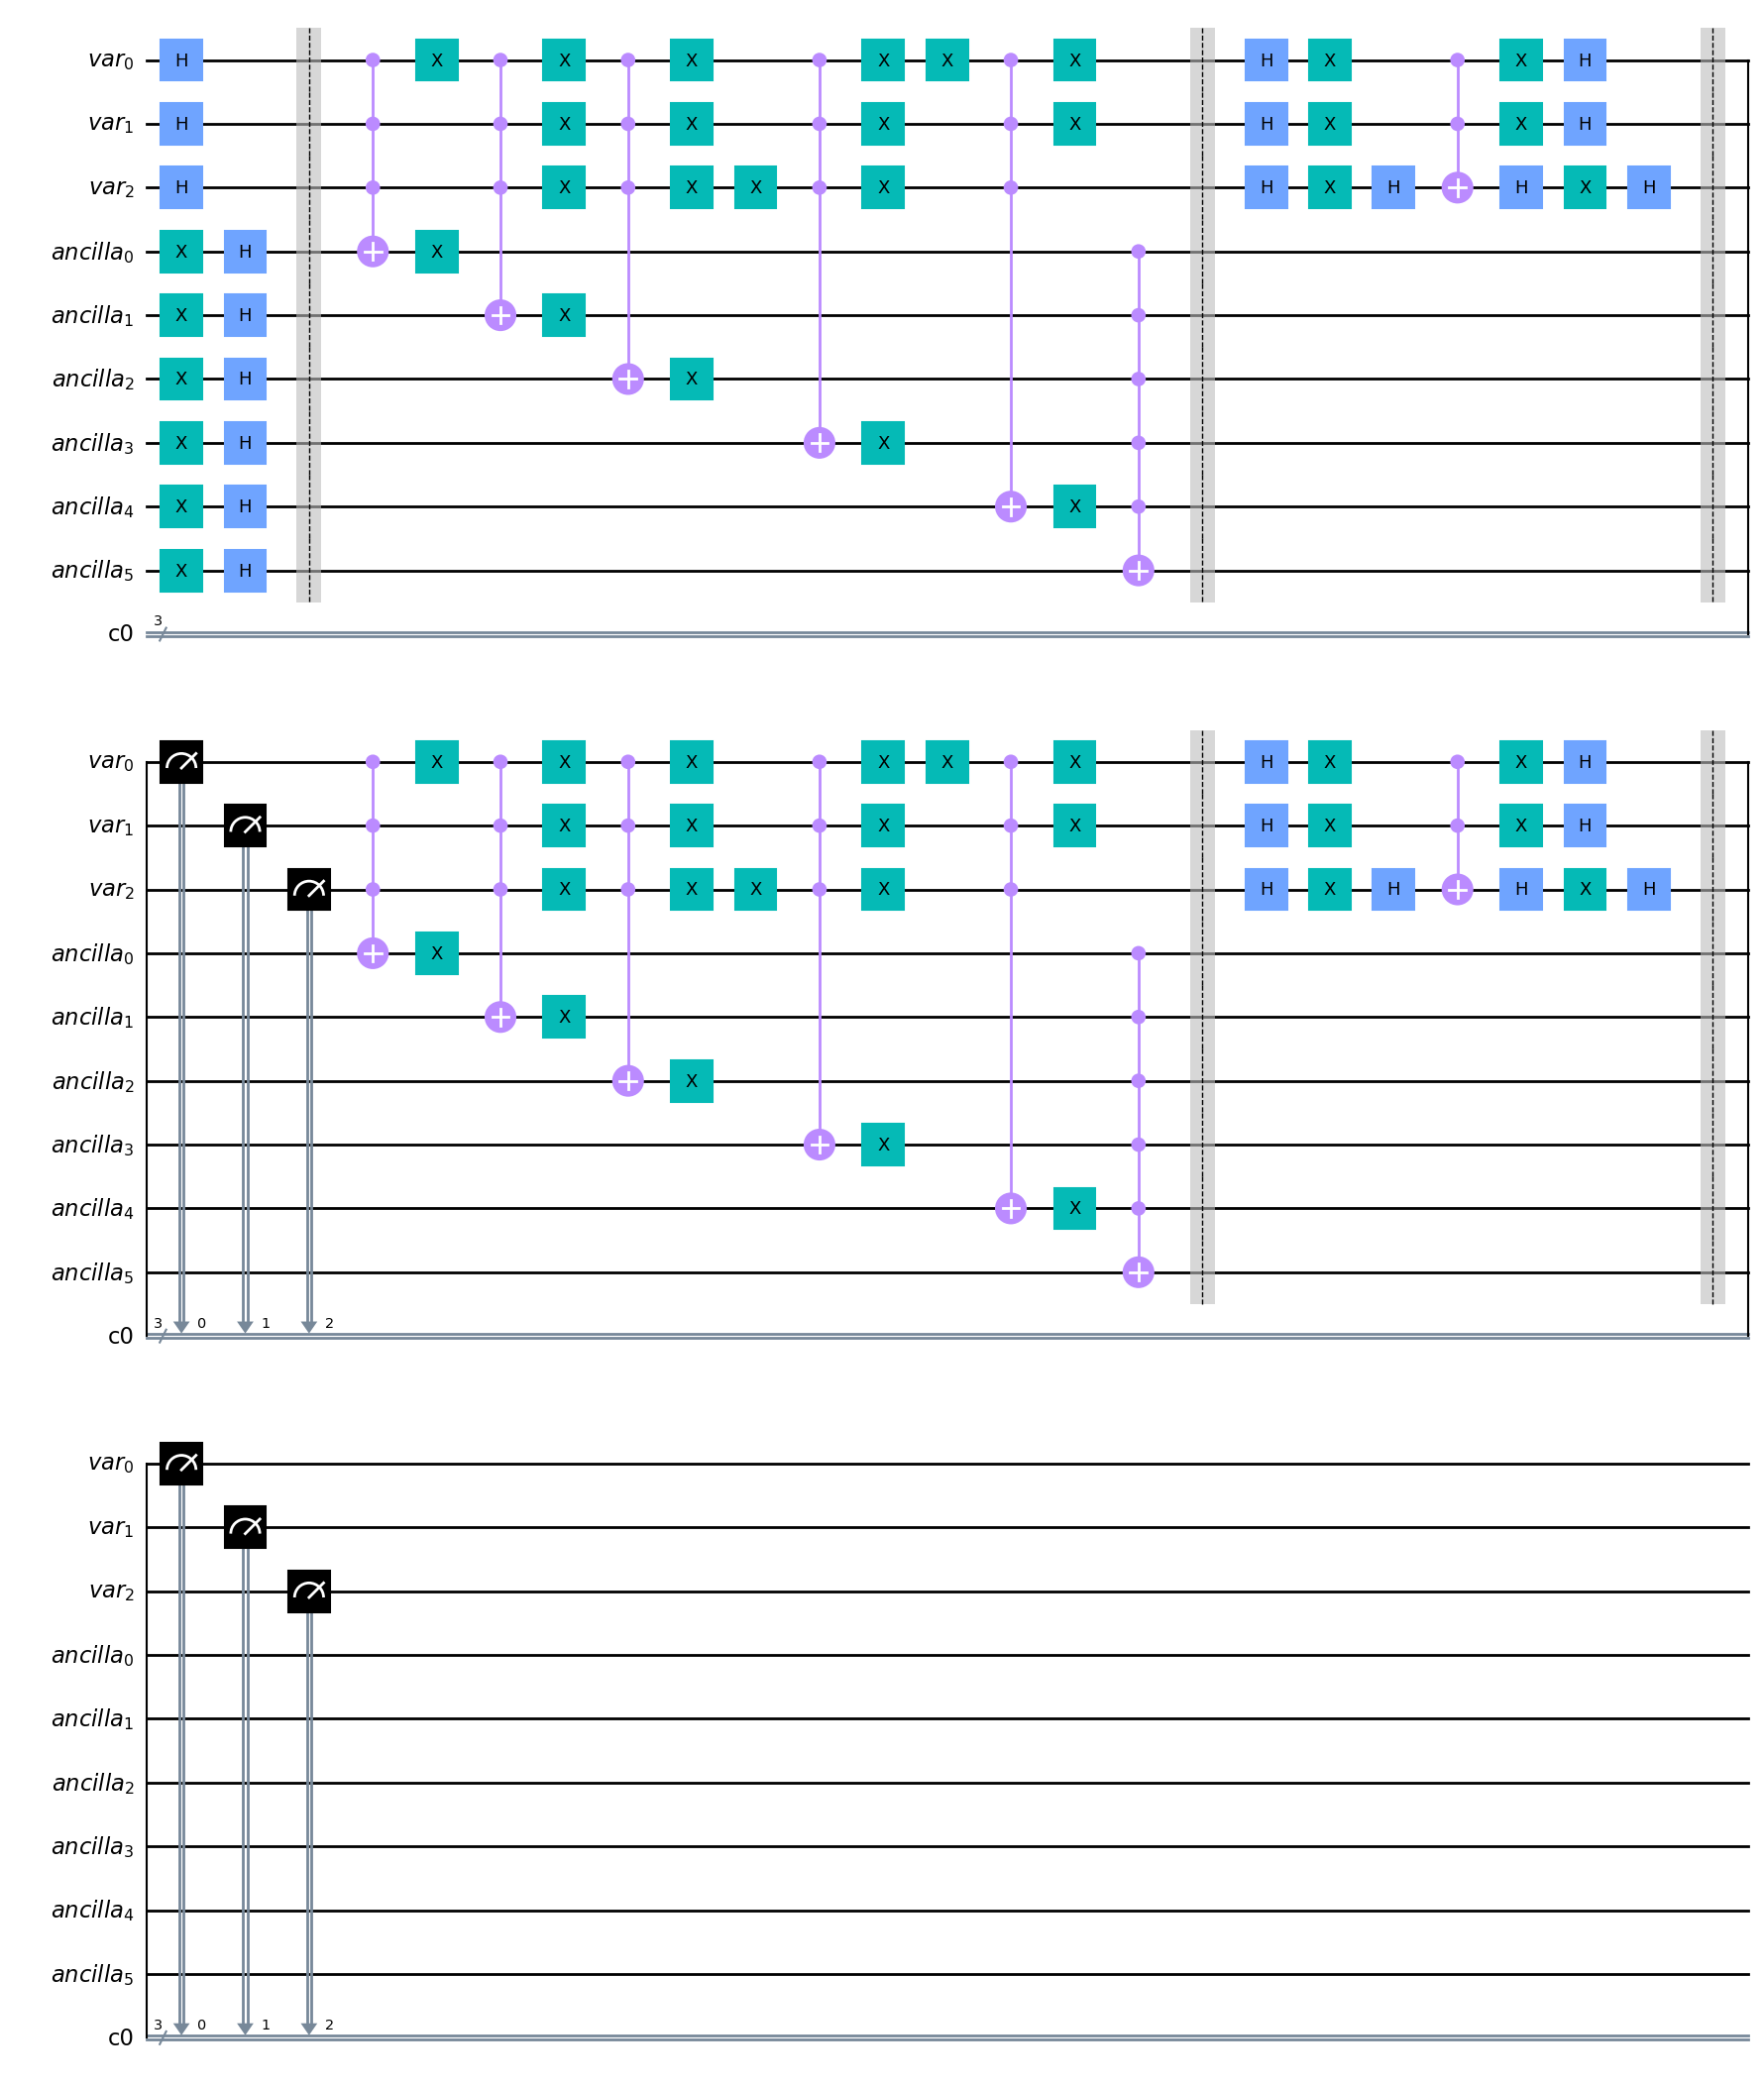

In [8]:
N = 2**3
iterations = int(np.floor(np.pi/4 * np.sqrt(N/3)))
print(iterations)
                  
for i in range(iterations):
    qc = qc.compose(oracle(qr, ancilla))
    qc = qc.compose(diffuser(qr, ancilla))
    
qc.measure(qr, cr)
qc.draw(output="mpl")
    

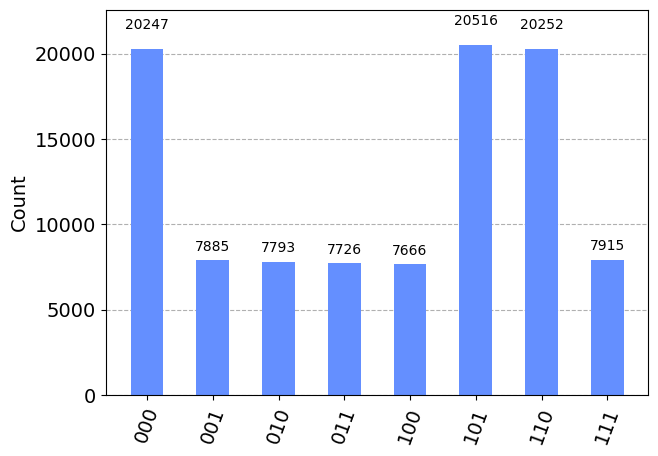

In [9]:
counts = execute_circuit(qc,shots=100000, reversed=True)
plot_histogram(counts)

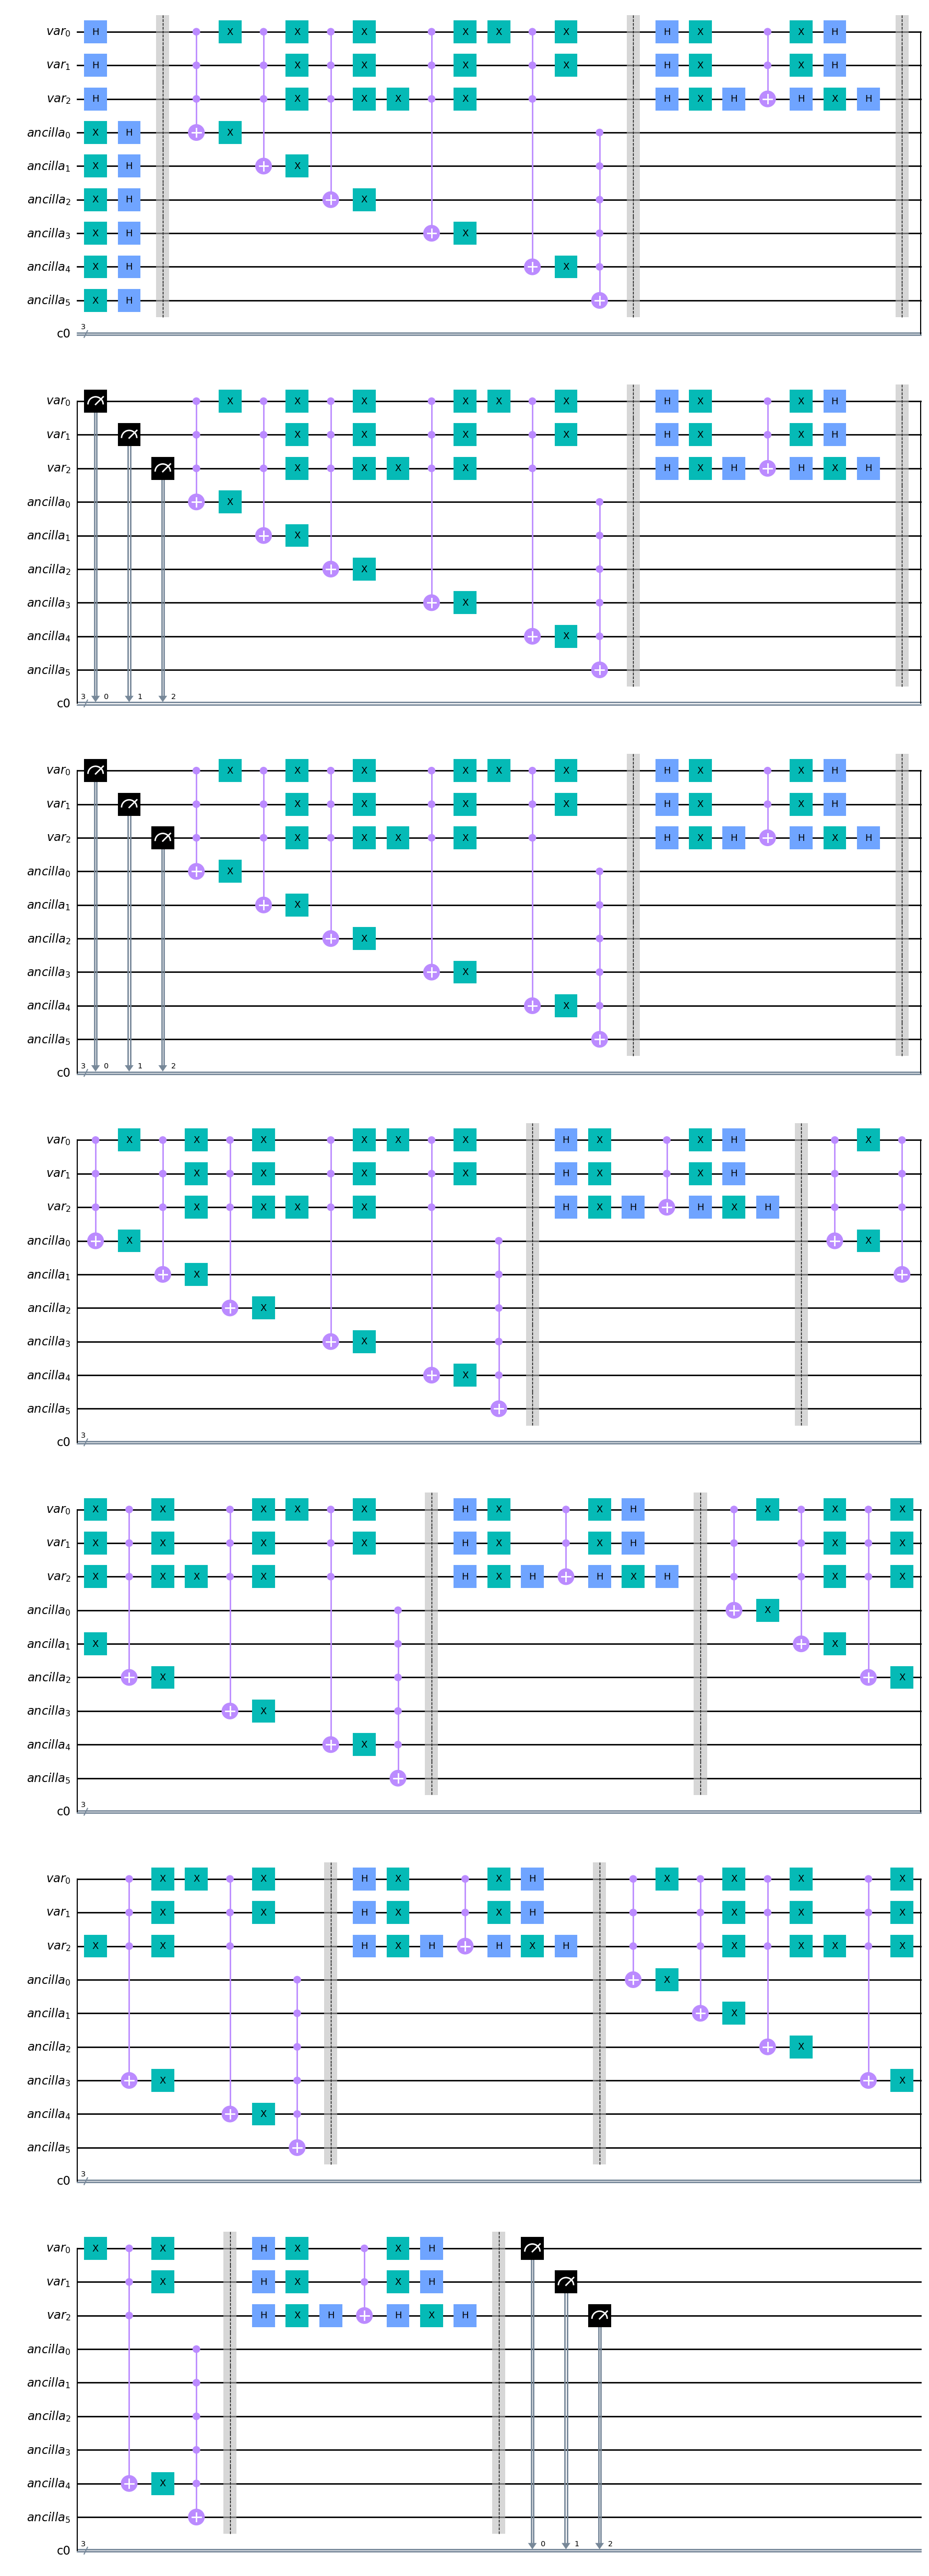

In [10]:
for i in range(5):
    qc = qc.compose(oracle(qr, ancilla))
    qc = qc.compose(diffuser(qr, ancilla))
    
qc.measure(qr, cr)
qc.draw(output="mpl")

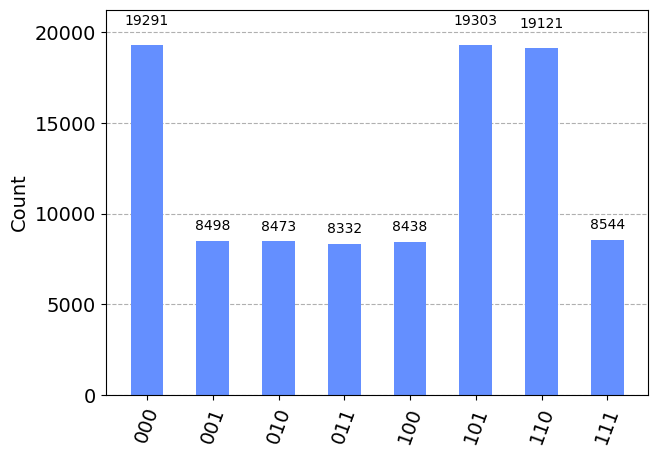

In [11]:
counts = execute_circuit(qc,shots=100000, reversed=True)
plot_histogram(counts)

## Análise dos resultados obtidos

Geralmente, o número ideal de iterações de Grover necessárias para obter uma solução é:
$$\frac{\pi}{4} * \sqrt{N/M}, \quad N = 2^{nº qubits}, M = nº soluções$$
<br><br>
Pela análise dos gráficos gerados acima (que representam os resultados obtidos), torna-se simples verificar que conforme o número de iterações aumenta, diminui a probabilidade de se obter as soluções pretendidas. Portanto, conclui-se que o número ideal de iterações é uma iteração apenas.